# Intelligence Summarizer
This work is meant to help understand how an LLM can be used to distil security content from multiple sources into a single summary. As part of this, exploration of various offline LLM and image generation models was performed. It does so by reading content from multiple input url's, summarizing them together, and generating an article with a title and image.

Note: To avoid plagiarism, articles from Wikipedia were used instead of actual intelligence articles.

In [ ]:
!pip install torch diffusers transformers sentencepiece scipy ftfy accelerate newspaper3k

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from transformers import T5Tokenizer, T5ForConditionalGeneration

import base64
from io import BytesIO
from IPython.display import Image, display
from newspaper import Article
import gc

In [3]:
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available. PyTorch will use CPU.")

GPU is available!


In [ ]:
if torch.cuda.is_available():
  tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")
  model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl").to("cuda")

  pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16)
  pipe.to("cuda")
else:
  tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")
  model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl")

  pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16)

In [5]:
# Get content from a list of articles

urls = [
    "https://en.wikipedia.org/wiki/Artificial_Intelligence_Act",
    "https://en.wikipedia.org/wiki/Artificial_intelligence",
]

articles = []

for url in urls:
  article = Article(url)
  article.download()

  article.parse()
  main_content = article.text
  articles.append(main_content)

print(articles[0][:200])

2024 European Union regulation on artificial intelligence

Regulation European Union regulation Title Artificial Intelligence Act[a] Made by European Parliament and Council History European Parliament


In [80]:
# Handle out of memory issues with Google Colab GPU
gc.collect()

input = "Summarize the following text: " + " ".join([f"{text}" for text in articles])
input_ids = tokenizer(f"{input}", return_tensors="pt", truncation=True).input_ids.to("cuda")
generated_output = model.generate(input_ids, temperature=1.0, max_length=1000)
generated_text = tokenizer.decode(generated_output[0], skip_special_tokens=True)

In [84]:
input_ids = tokenizer(f"Create a title for the news article:\n\n{generated_text}", return_tensors="pt").input_ids.to("cuda")
generated_output = model.generate(input_ids, do_sample=True, temperature=1.0, max_length=2500, num_return_sequences=1)
title = tokenizer.decode(generated_output[0], skip_special_tokens=True)

In [83]:
image = pipe(title).images[0]
image_path = 'image.png'
image.save(image_path)

  0%|          | 0/50 [00:00<?, ?it/s]

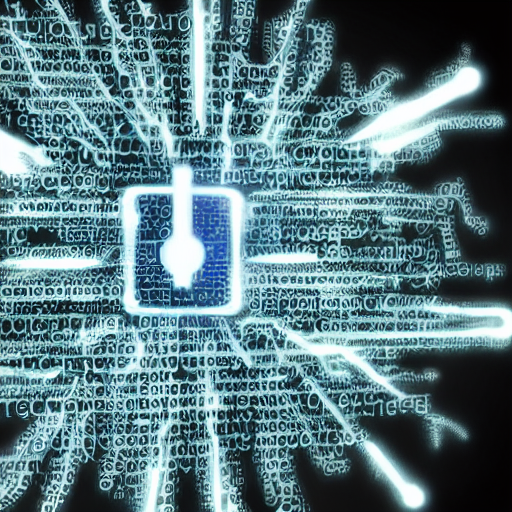

Regulation artificial intelligence Artificial Intelligence Act


"The Artificial Intelligence Act (AI Act)[a] is a European Union regulation concerning artificial intelligence (AI). It establishes a common regulatory and legal framework for AI within the European Union (EU).[1] Proposed by the European Commission on 21 April 2021,[2] it passed the European Parliament on 13 March 2024,[3] and was unanimously approved by the EU Council on 21 May 2024.[4] The Act also creates a European Artificial Intelligence Board to promote national cooperation and ensure compliance with the regulation.[5] Like the EU's General Data Protection Regulation, the Act can apply extraterritorially to providers from outside the EU if they have users within the EU.[6] It covers all types of AI across a broad range of sectors, with exceptions for AI systems used solely for military, national security, research and non-professional purposes.[7] As a piece of product regulation, it does not confer rights on individuals, but regulates the providers of AI systems and entities us

In [79]:
display(Image(filename=image_path))
print(title)
display(generated_text)

# Summary
This work showed the use of offline LLM's to summarize content from multiple articles. Notes:
1. A model with a larger number of tokens allowed should be used in order to properly summarize content of variable length. However using workarounds such as removing stopwords may help.
1. This could be an expensive operation if used in conjunction with LLM's as a Service and exposed publicly without strong limitations.
1. An automated process for collecting and clustering similar articles would be useful.
1. Better summaries would be achieved with fine tuning, to include specific desired details.